# Strain rates comparison Tutorial

In this tutorial we will walk through how to understand various methods for calculating strain rate and how they are similar and different. 
Strain rate is related to the spatial derivatives of velocity, just as strain is related to the spatial derivatives of displacements: 
$$ \epsilon_{ij} = 0.5 (\partial \dot{u}_y/\partial x + \partial \dot{u}_x / \partial y) $$

In this tutorial we will compare strain rates for several methods and calculate various statistics of interest. 

## Interpolation models

The methods in Strain_2D used to calculate strain rate mostly (all except Delaunay) involve some type of interpolation. 
Interpolation introduces uncertainty, since the surface velocities are not known everywhere. 
Different methods have different approaches to handle this uncertainty; however, each method has to define a way to handle the three fundamental characteristics of an interpolation scheme: 
1. The degree of fit to the data (except for certain approaches which use the data exactly as is; this is not ideal as the data have errors that get propagated through to the strain rate). 
2. The degree of smoothness; or the behavior of the interpolated field at very short length scales. E.g. a surface can be continuous but not differentiable, or it could be both continuous and differentiable. 
3. The spatial correlation length scale - a distance scale the describes the characteristic length over which measurements are correlated. The assumption is that once you get far enough away from a point, the data no longer helps you to interpolate the value at that point. 

These three fundamental properties of any interpolation scheme can be visualized using correlation plots as shown below

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from scipy.spatial.distance import cdist, pdist

In [2]:
# Setup some formatting and plot commands
SMALL_SIZE = 7
MEDIUM_SIZE = 10
BIGGER_SIZE = 11

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def plotCov(h, *args, **kwargs):
    f = plt.figure(figsize=(4, 2.5), dpi=300)
    for k,arg in enumerate(args):
        if np.mod(k,2)==0:
            plot_sym = '-'
        elif np.mod(k,3)==0:
            plot_sym = '-.'
        else:
            plot_sym = '--'
        if 'namelist' in kwargs.keys():
            plt.plot(h, arg, plot_sym, label=kwargs['namelist'][k])
        else:
            plt.plot(h, arg, plot_sym)
    plt.ylim([-0.1, np.max(np.max([arg for arg in args])) + 0.1])
    plt.xlim([0,10])
    plt.legend()
    plt.axhline(y=0,linestyle='--', c='k', linewidth=0.5)
    plt.xlabel('Distance')
    plt.ylabel('Covariance')

White noise is a special type of model which can be added to any of the other models. 

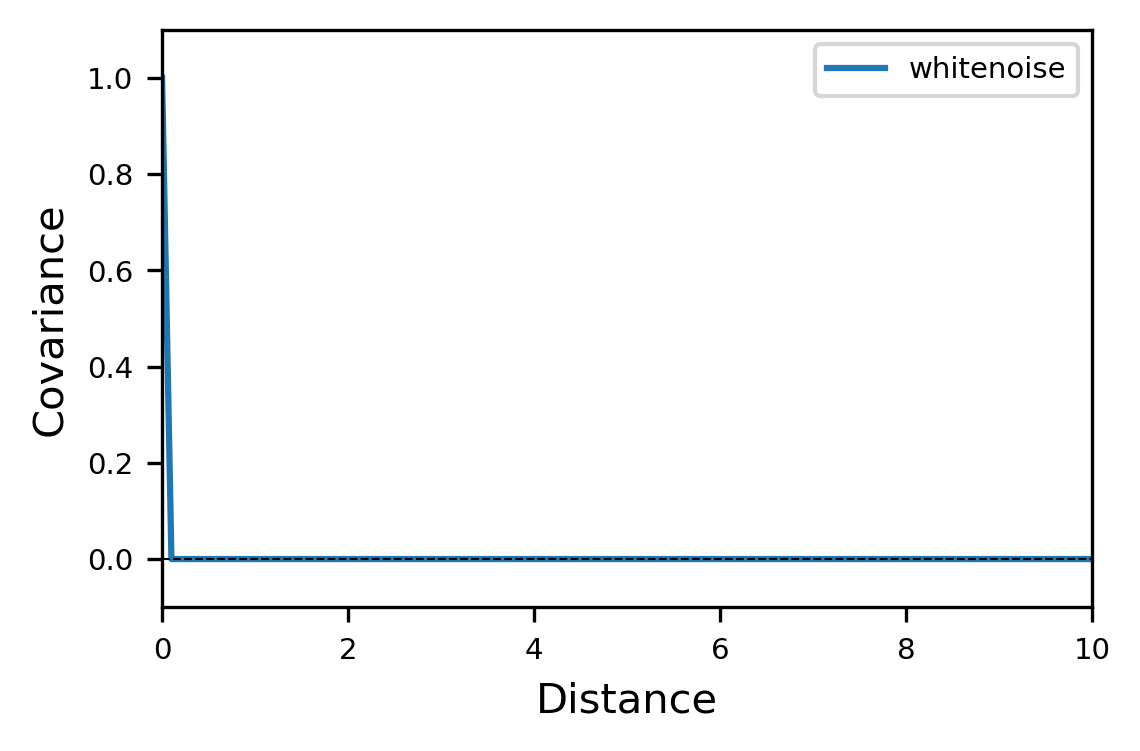

In [3]:
# distance
h = np.linspace(0,20, 200)

# various covariance functions

# A white noise or "nugget" model. Points are always perfectly correlated to themselves, otherwise the correlation is zero
# The nugget is the variance of the white-noise process
def whiteNoise(h, nugget):
    out = np.zeros(h.shape)
    out[h==0] = nugget
    return out

plotCov(h, whiteNoise(h, 1), namelist=['whitenoise'])

We can model the various interpolation methods as having a particular correlation length scale (range), total variance (sill), and point-wise variance (nugget). 

In addition, different models behave differently at short and long distances. 
In the next section, note the differences between models and what distance scale is required to reach zero correlation. 
Also note how the curves approach the y-intercept, either at a high angle or flat. 

In [4]:
# A Gaussian model, described by a variance scale (sill), correlation length (range), and the data noise (nugget)
# VISR and geostats can both use Gaussian covariance models to calculate weights
def Gaussian(h, sill, range, nugget=None):
    out = sill * np.exp(-.5 * np.square(h / range))
    return [out + nugget * (h==0) if nugget is not None else out][0]

In [5]:
# An Exponential model, with the same parameters as a Gaussian but a different behavior at short distances
# geostats can use an Exponential covariance model to calculate weights
def Exponential(h, sill, range, nugget=None):
    out = sill * np.exp(-.5 * (h / range))
    return [out + nugget * (h==0) if nugget is not None else out][0]

In [6]:
# VISR has the option to use a quadratic function to calculate weights
def quadratic(h, sill, range, nugget=None):
    denom = 1 + np.square(h/range)
    return (sill / denom) + nugget * (h == 0)

In [7]:
# if you can have a quadratic you can have a linear! Not currently used by any of the Strain_2D methods but one could implement one
# this is 1/r, or Inverse-distance weighting
def linear(h, sill, range, nugget=None):
    output = sill - (sill / range) * h
    output[output < 0] = 0.
    return output + nugget * (h == 0)

In [8]:
# Local average gradient (LAG) uses a boxcar-like window function
# Note that this is *NOT* going to work as a covariance matrix, because it will in general not be positive semidefinite
def boxcar(h, sill, range, nugget=None):
    return sill * (h < range) + nugget * (h == 0)

In [12]:
# GPSgridder uses Green's functions for point (body) forces in an elastic thin plate to interpolate. The basic solution is ln(r)
def thin_plate(h, sill, range, nugget=None):
    return sill- (1/range) * np.log(h + 1)

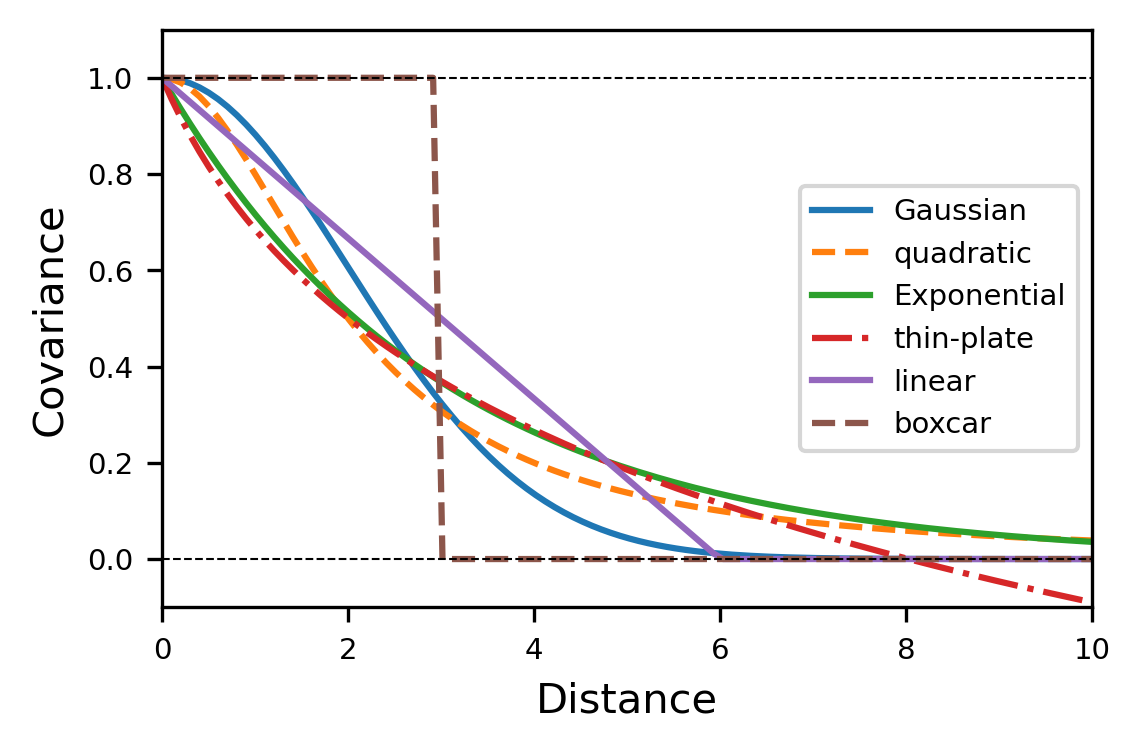

In [13]:
# We can compare multiple models 
# Note that even when the effective length scales are similar, the behavior is different due to the different models
# plotCov(
#     h, 
#     Gaussian(h, 1, 2, 0), 
#     Exponential(h, 1, 1.5, 0),
#     quadratic(h, 1, 2, 0),
#     # linear(h, 1, 6, 0),
#     # boxcar(h, 1, 3, 0),
#     namelist=['Gaussian', 'Exponential', 'quadratic',],
# )
plotCov(
    h, 

    # Gaussian and quadratic models have a similar short-distance behavior while Gaussian decays faster at long distances
    Gaussian(h, 1, 2, 0), 
    quadratic(h, 1, 2, 0),
    
    # Exponential and thin-plate models behave similarly at short distances but diverage at long distances
    # The thin-plate model is not positive semi-definite
    Exponential(h, 1, 1.5, 0),
    thin_plate(h, 1, 2.2, 0),
    
    # Linear and boxcar models can be thought of as simple approximations to a gradually decaying curve
    linear(h, 1, 6, 0),
    boxcar(h, 1, 3, 0),
    
    namelist=['Gaussian', 'quadratic','Exponential', 'thin-plate', 'linear', 'boxcar'],
)

plt.axhline(y=1,linestyle='--', c='k', linewidth=0.5)

From the plot above, we can see that each model behaves slightly differently yet has similarities. One possible exception is the thin-plate model, which does not decay with distance, but this is not a problem as long as only the area inside the area containing data is considered; extrapolation would be unstable with this function. 

## Data inputs

Strain_2D takes a space-delimited file in a specific format. The format is shown below: 

In [14]:
# The text file header uses the hash mark for reading in awk, so we will pass the names explicitly
import pandas as pd
df = pd.read_csv(
    '../test/testing_data/NorCal_stationvels.txt', 
    delim_whitespace=True, 
    skiprows=1, 
    names=['Lon', 'Lat', 'VE', 'VN', 'VU', 'SE', 'SN', 'SU', 'ID']
)

In [15]:
# The provided example dataset for northern california
df.head()

,Lon,Lat,VE,VN,VU,SE,SN,SU,ID
0,-122.670170,42.180691,-1.42,6.80,-1.05,0.18,0.13,0.68,ASHL
1,-121.049065,42.406845,-2.56,4.18,-0.52,0.15,0.15,0.77,BLY1
2,-122.152556,37.919406,-14.69,17.02,0.30,0.18,0.14,0.47,BRIB
3,-124.563345,42.836100,6.51,13.84,0.18,0.15,0.12,0.36,CABL
4,-122.119313,37.724117,-15.68,19.39,-0.20,0.14,0.17,0.46,CHAB


The velocity components get interpolated separately except in the case of _gpsgridder_, which allows for explicit coupling between the components. Other methods may have indirect coupling when using the same interpolation parameters for both components. 

<AxesSubplot:xlabel='Lon', ylabel='Lat'>

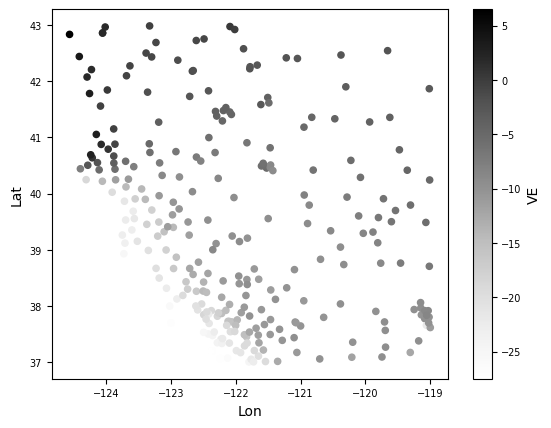

In [16]:
# plot the easting velocities
df.plot.scatter(x='Lon', y='Lat', c='VE')

<AxesSubplot:xlabel='Lon', ylabel='Lat'>

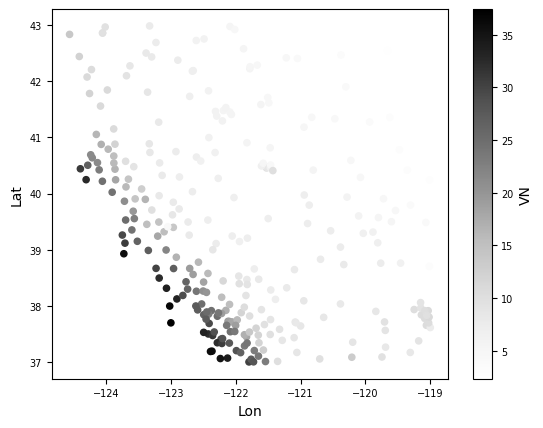

In [17]:
# Plot the northing velocities
df.plot.scatter(x='Lon', y='Lat', c='VN')

## Configuration file
The configuration file has a standard format shown below: 
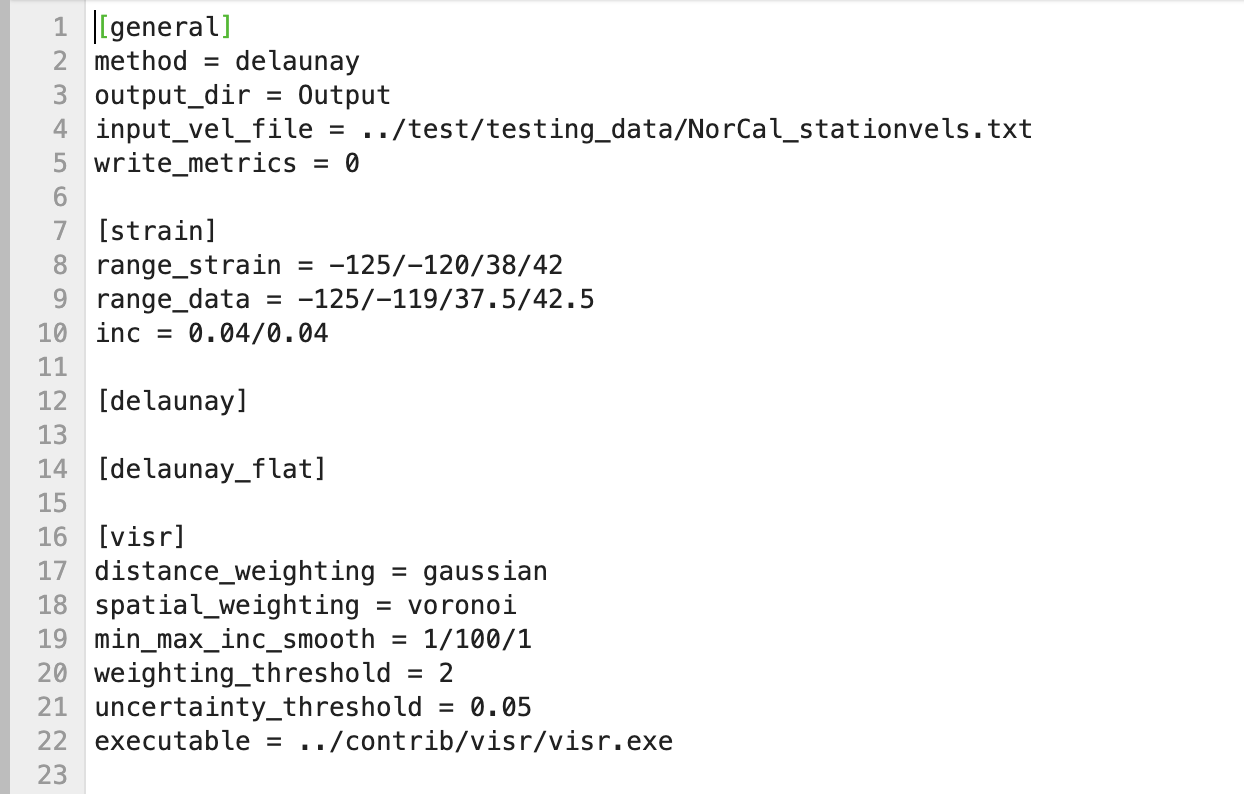

General runtime parameters are at the top, followed by the parameters required by each method. 
Only the method listed after "method = " in the general configuration will be run. 
When a particular method gets called, the code will look at the configuration options given in the list under that methods' header (in square brackets). 

Currently supported methods include delaunay, delaunay_flat, visr, gpsgridder, loc_avg_grad, wavelets, geostats, and strain_comparison. 

## Running the code

Running the --help command will print out example usage and the currently available modules

In [19]:
!strain_rate_compute.py --help

  Welcome to a geodetic strain-rate calculator.

  USAGE 1: strain_rate_compute.py config.txt      <-- for running a strain calculation
  USAGE 2: strain_rate_compute.py --help          <-- for printing help message
  USAGE 3: strain_rate_compute.py --print_config  <-- for writing example config file

Available modules are:
  delaunay
  delaunay_flat
  geostats
  gpsgridder
  loc_avg_grad
  wavelets
  visr
 


In [20]:
# !strain_rate_compute.py --print_config # to print out an example configuration file in the current directory

In order to calculate strain rates, make sure that the "range_strain" and "range_data" are set to the proper bounding boxes (WESN format). 
Data outside of "range_data" will be ignored when calculating strain rate. 
Strain rates will only be calculated for the "range_strain" bounding box. 

For this example we will use the example data set that is available in the test folder. 
We have provided three example files which will run the _gpsgridder_, _local average gradient_, and _geostats_ methods. 

In [26]:
# Once the configuration file is properly defined, running the code is as simple as: 
!strain_rate_compute.py 00_example_strain_config.txt


------------------------------
Hello! We are...
   Computing strain using : delaunay 
   Input data from        : ../test/testing_data/NorCal_stationvels.txt
   Calculation range      : [-125.0, -120.0, 38.0, 42.0]
   Putting the outputs    : Output/delaunay/ 

------------------------------
Reading file ../test/testing_data/NorCal_stationvels.txt 
284 stations before applying cleaning.
233 stations after imposing bounding box.

------------------------------
Computing strain via Delaunay on a sphere, and converting to a grid.
Number of triangle elements: 454
Producing gridded dataset of: Exx
Producing gridded dataset of: Exy
Producing gridded dataset of: Eyy
Producing gridded dataset of: Rot
------------------------------
Writing 1d outputs:
Computing strain invariants for 1d dataset with length 454.
Writing output file Output/delaunay/rot_polygons.txt 
Writing output file Output/delaunay/I2nd_polygons.txt 
Writing output file Output/delaunay/Dilatation_polygons.txt 
Writing output f

Outputs from Strain_2D are stored in the "Output" folder, which can be changed in the config file. 

In [27]:
# A bunch of files and images get generated by Strain_2D
!ls Output/delaunay

00_example_strain_config.txt max_shear_polygons.txt
Dilatation_polygons.txt      mycpt.cpt
I2nd.png                     negative_eigs.txt
I2nd_polygons.txt            negative_eigs_polygons.txt
azimuth.png                  obs_vels.txt
azimuth_polygons.txt         polygon_I2nd.png
delaunay_strain.nc           polygon_dilatation.png
dilatation.png               positive_eigs.txt
example_strain_config.txt    positive_eigs_polygons.txt
exx_polygons.txt             residual_vels.txt
exy_polygons.txt             rot_polygons.txt
eyy_polygons.txt             rotation.png
landmask.grd                 strain_metrics.txt
max_shear.png                tempgps.txt


In [28]:
# You can also look at strain_metrics.txt for some summary metrics if metrics=1 is in your config
# Note that delaunay has no misfit! It fits the data exactly
with open('Output/delaunay/strain_metrics.txt', 'r') as f:
    for line in f.readlines():
        print(line.strip())

Mu: 30.000000 GPa
Depth: 11.000000 km
Infile: Output/delaunay/delaunay_strain.nc
Moment rate accumulation: 7.548271 e18 N-m / year

Median absolute deviation: 0.00000 mm/yr
Median chi2: 0.00000


In [29]:
# You can get all the data generated by Strain_2D in the netcdf file generated 
ds = xr.load_dataset('Output/delaunay/delaunay_strain.nc')
print(ds) 

<xarray.Dataset>
Dimensions:     (y: 101, x: 126)
Coordinates:
  * x           (x) float64 -125.0 -125.0 -124.9 -124.9 ... -120.1 -120.0 -120.0
  * y           (y) float64 38.0 38.04 38.08 38.12 ... 41.88 41.92 41.96 42.0
Data variables:
    Ve          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Vn          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    exx         (y, x) float64 nan nan nan nan nan ... 4.718 4.718 4.718 4.718
    eyy         (y, x) float64 nan nan nan nan ... -8.733 -8.733 -8.733 -8.733
    exy         (y, x) float64 nan nan nan nan ... -0.1734 -0.1734 -0.1734
    azimuth     (y, x) float64 nan nan nan nan ... 0.7386 0.7386 0.7386 0.7386
    rotation    (y, x) float64 nan nan nan nan nan ... 16.56 16.56 16.56 16.56
    I2          (y, x) float64 nan nan nan nan ... -20.61 -20.61 -20.61 -20.61
    dilatation  (y, x) float64 nan nan nan nan ... -4.016 -4.016 -4.016 -4.016
    max_shear   (y, x) float64 nan nan nan nan nan ... 

In [30]:
# You can look at misfit and total moment metrics if they are generated

### Plots
Let's look at some of the plots generated by Strain_2D. 
Plots are found in `Output/<method name>`

Dilatation rate:
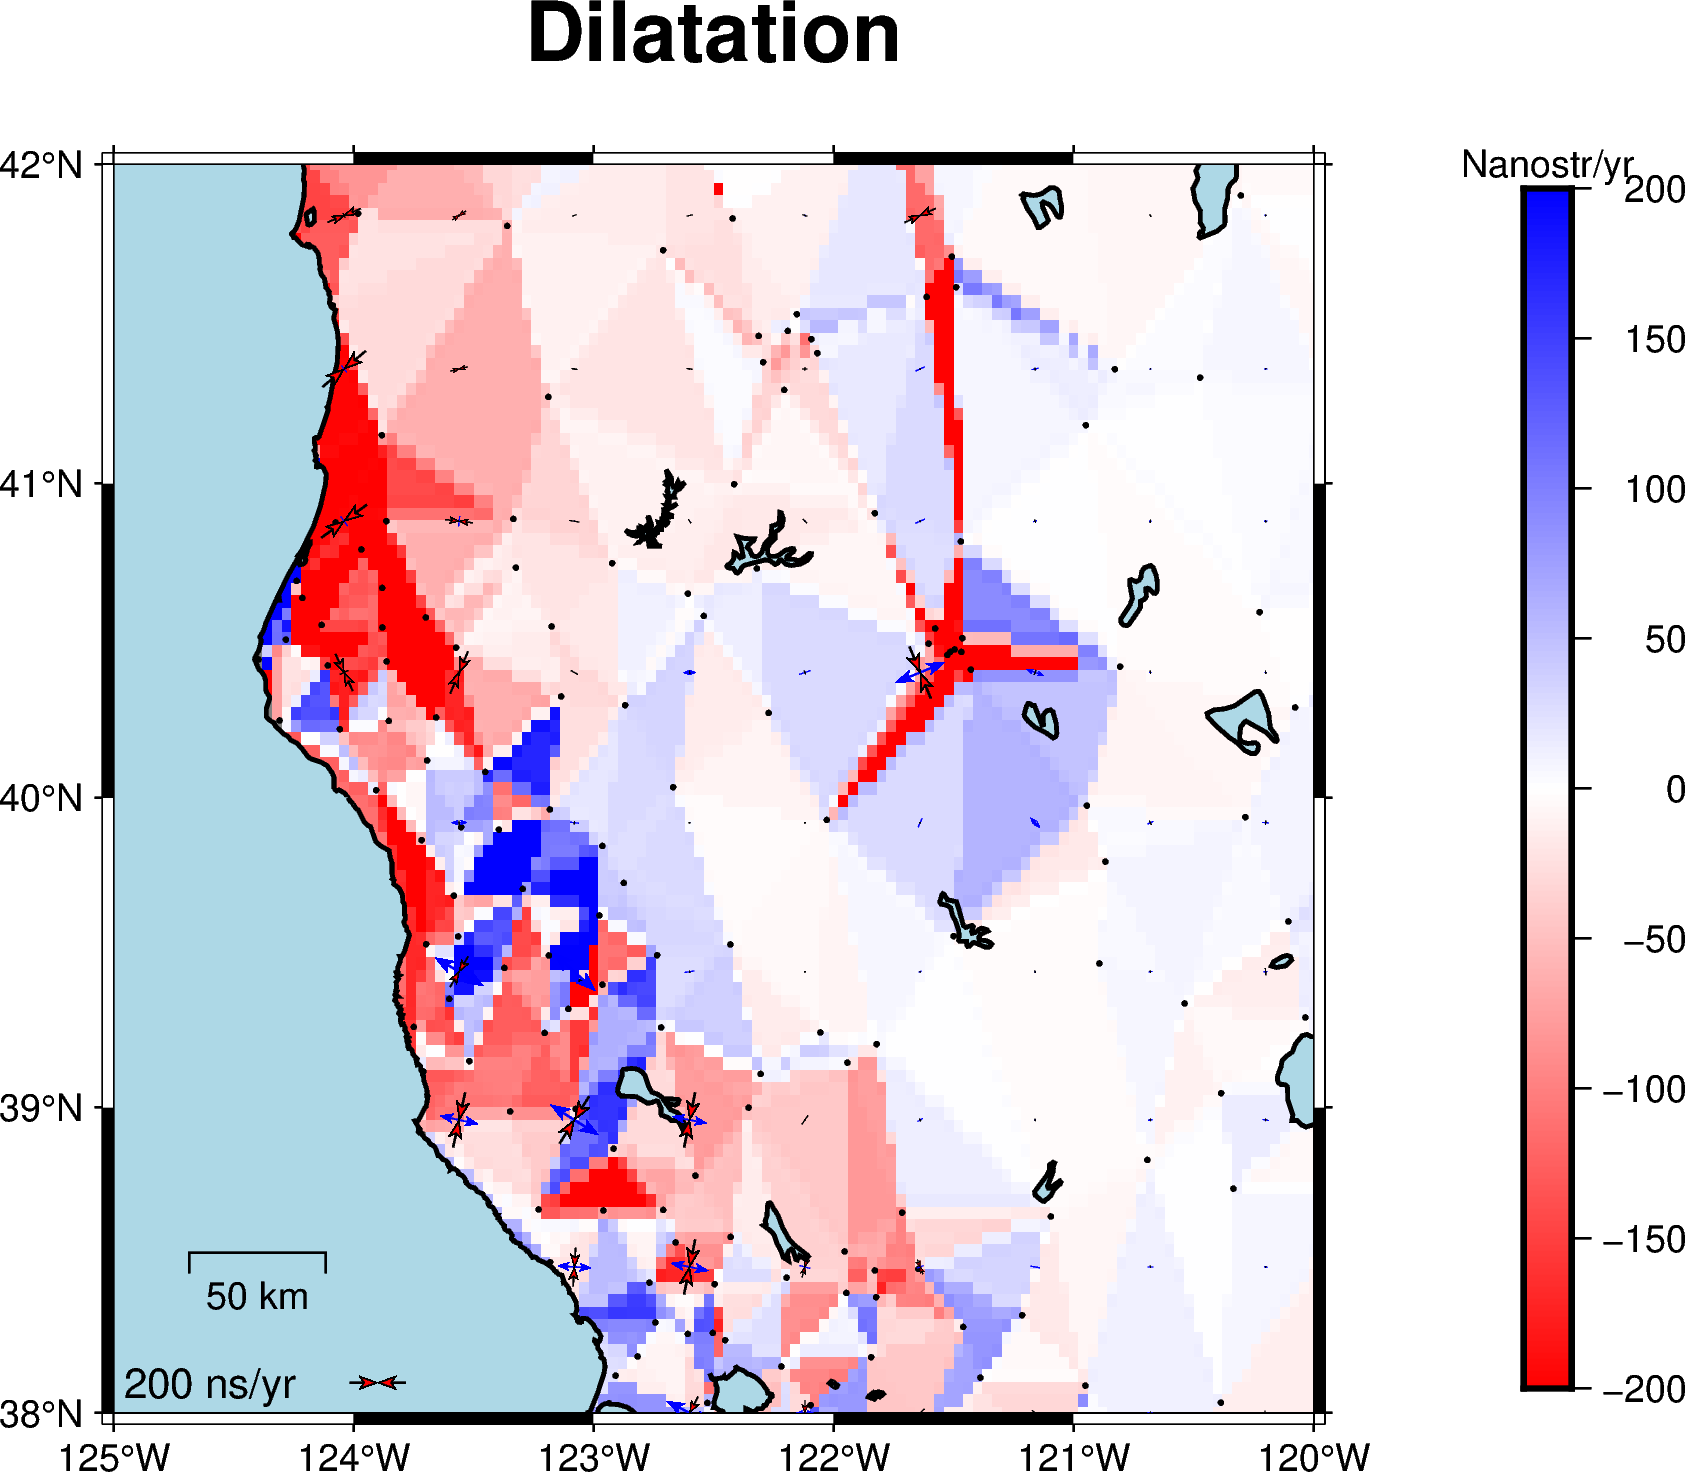

Max shear strain rate:
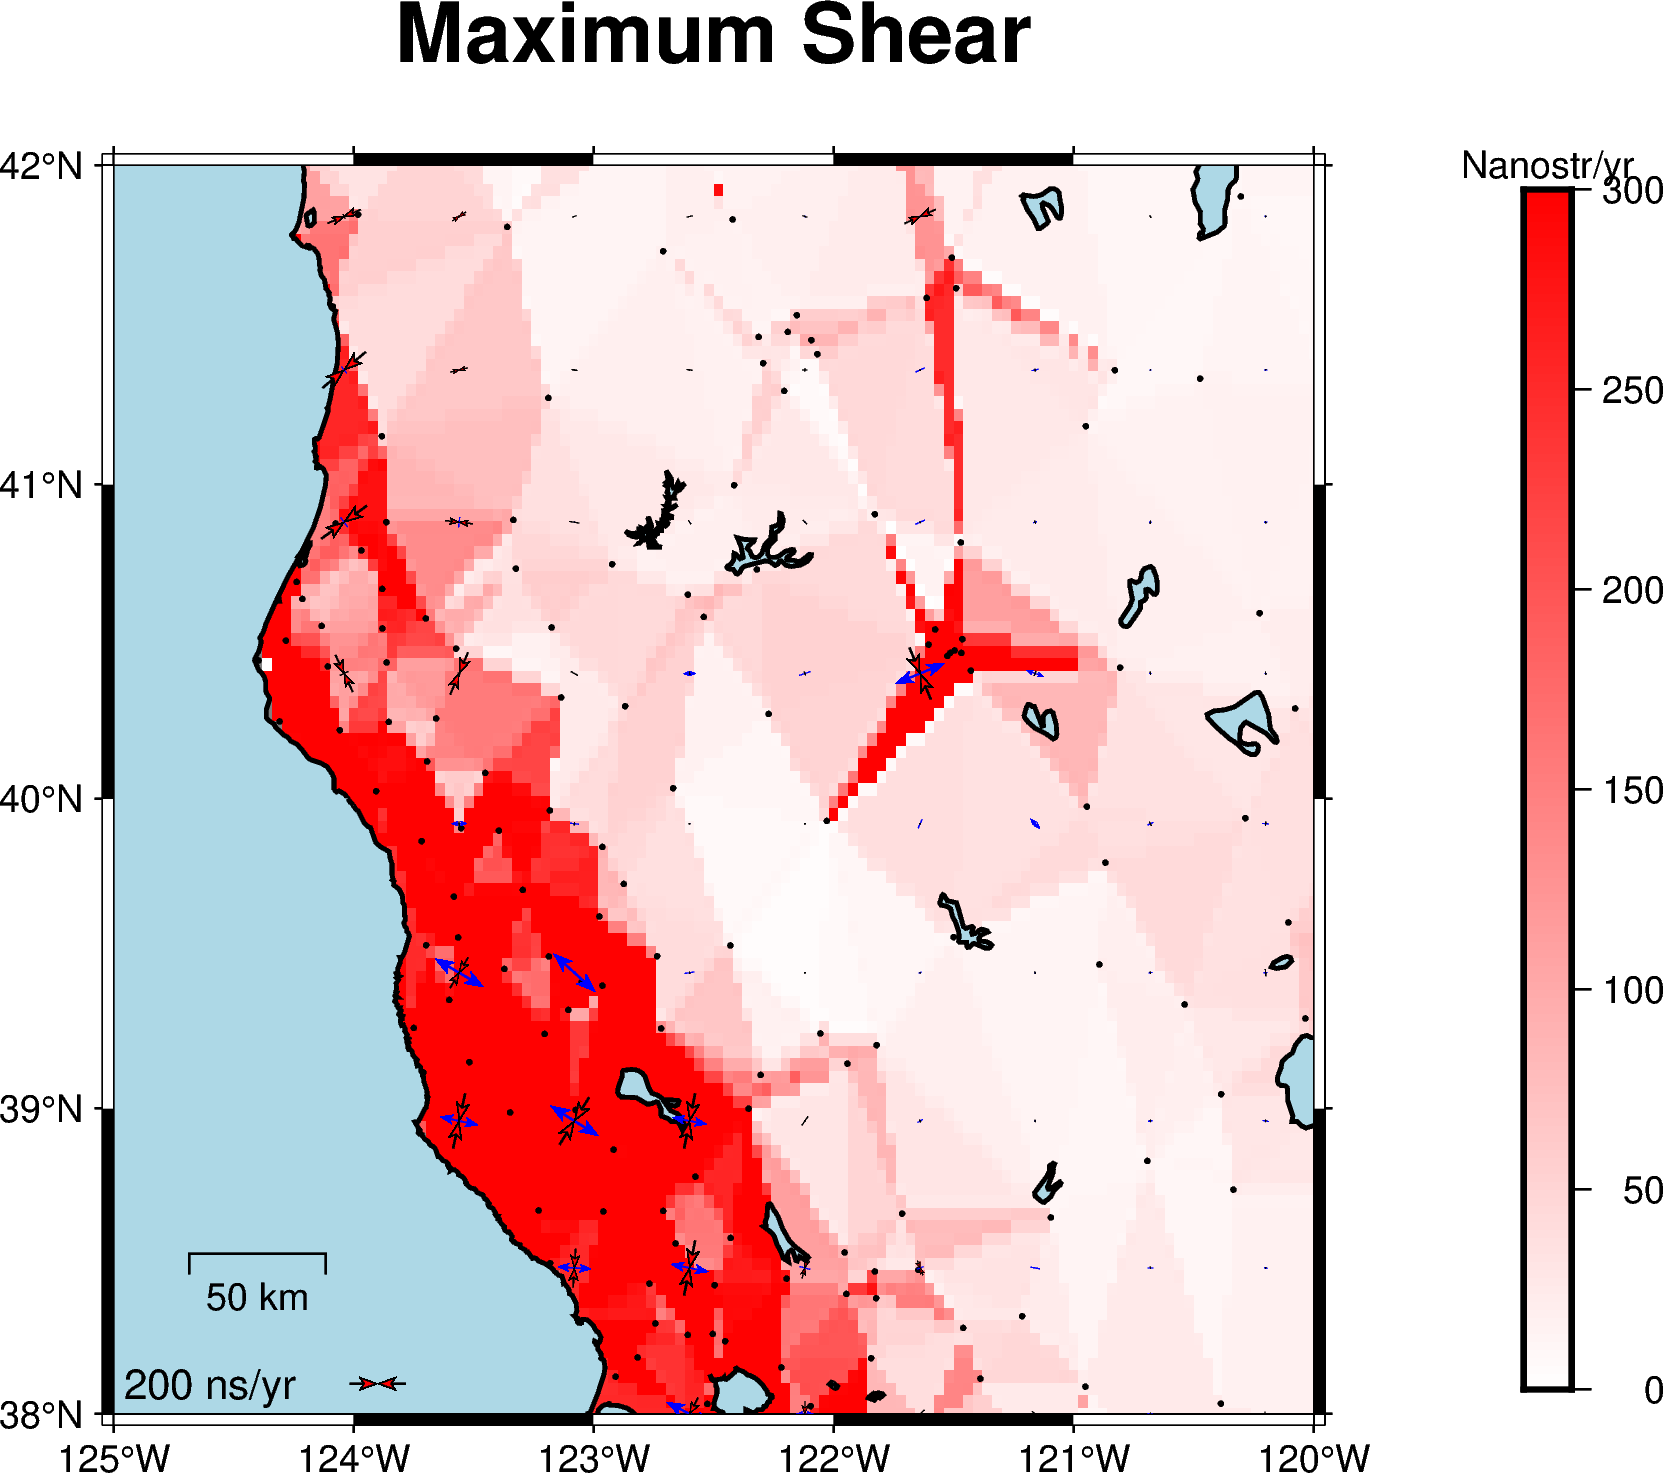

Delaunay triangulation provides direct estimates of strain rates without additional interpolation; the assumption is that of constant strain in each triangle.

### Geostatistics method

Other methods besides delaunay require various parameters. 
We can use geostats as an example. Geostats requires three parameters for each velocity component, and a choice about the spatial structure function (variogram model) to use. 
Let's compare each. 

To calculate a variogram, we need the distance and the semivariance between every pair of points. 
Semivariance is defined as:
$$ \gamma(v_1^1, v_2^1) = (v_2^1 - v_1^1)^2 / 2 $$
where the subscript is the station index and the superscript is the velocity component. 

In [31]:
# we should convert the lat/lon to a local coordinate system, but we'll simplify and just use lat/lon for now
h = pdist(df[['Lon', 'Lat']].values)
gam_E = 0.5 * np.square(pdist(np.broadcast_to(df['VE'].values, (1, len(df['VE'].values))).T))
gam_N = 0.5 * np.square(pdist(np.broadcast_to(df['VN'].values, (1, len(df['VN'].values))).T))

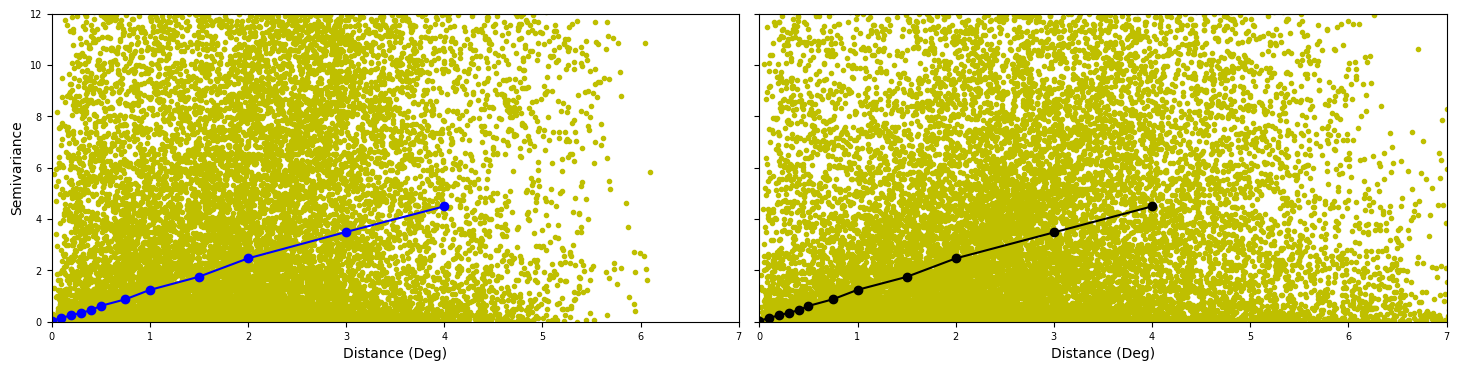

In [32]:
# Plot the raw semivariances
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18, 4))
ax1.scatter(h, gam_E, marker='.', c='y')
ax2.scatter(h, gam_N, marker='.', c='y')

# Add the binned (empirical) semivariance
bins = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5])
digitized = np.digitize(gam_E, bins)
bin_means_E = [gam_E[digitized == i].mean() for i in range(1, len(bins))]
digitized = np.digitize(gam_N, bins)
bin_means_N = [gam_N[digitized == i].mean() for i in range(1, len(bins))]

ax1.plot(bins[:-1], bin_means_E, '-ob')
ax2.plot(bins[:-1], bin_means_N, '-ok')

ax1.set_ylabel('Semivariance')
ax1.set_xlabel('Distance (Deg)')
ax2.set_xlabel('Distance (Deg)')
ax1.set_xlim([0, 7])
ax2.set_xlim([0, 7])
plt.ylim([0, 12])
plt.subplots_adjust(wspace=0.03, hspace=0.)

In [33]:
# Now we can fit a Variogram model
# The choices in geostats are Exponential and Gaussian
# The Variogram is the inverse of the covariance
def Exp_vario(h, sill, range, nugget=0):
    return (sill + nugget) - Exponential(h, sill, range, nugget)
def Gauss_vario(h, sill, range, nugget=0):
    return (sill + nugget) - Gaussian(h, sill, range, nugget)

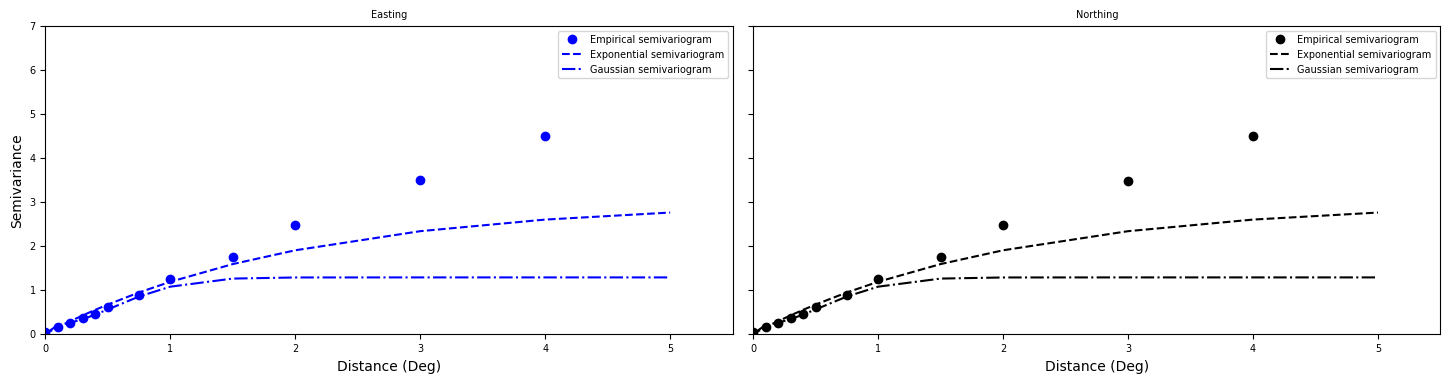

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18, 4))

# plot the empirical semivariances
ax1.plot(bins[:-1], bin_means_E, 'ob', label='Empirical semivariogram')
ax2.plot(bins[:-1], bin_means_N, 'ok', label='Empirical semivariogram')

# plot the model semivariances
# Experiment with the parameter values to get a good match
ax1.plot(bins, Exp_vario(bins, 3, 1, 0), '--b', label='Exponential semivariogram')
ax2.plot(bins, Exp_vario(bins, 3, 1, 0), '--k', label='Exponential semivariogram')
ax1.plot(bins, Gauss_vario(bins, 1.1, .55, 0.18), '-.b', label='Gaussian semivariogram')
ax2.plot(bins, Gauss_vario(bins, 1.1, .55, 0.18), '-.k', label='Gaussian semivariogram')
ax1.legend()
ax2.legend()

ax1.set_title('Easting')
ax2.set_title('Northing')
ax1.set_ylabel('Semivariance')
ax1.set_xlabel('Distance (Deg)')
ax2.set_xlabel('Distance (Deg)')
ax1.set_xlim([0, 5.5])
ax2.set_xlim([0, 5.5])
plt.ylim([0, 7])
plt.subplots_adjust(wspace=0.03, hspace=0.)

From the plots above, it is clear that neither an Exponential or Gaussian model fit all the data points. 
However, looking back at the figure above showing all the raw semivariances suggests that there are not enough data points at Distance > 3 deg to make a good fit, so we don't need to worry too much that those points are a bit off the line. 
We will use the Gaussian model as an example. 

In [35]:
!strain_rate_compute.py 01_strain_config_geostats.txt


------------------------------
Hello! We are...
   Computing strain using : geostats 
   Input data from        : ../test/testing_data/NorCal_stationvels.txt
   Calculation range      : [-125.0, -120.0, 38.0, 42.0]
   Putting the outputs    : Output/geostats/ 

------------------------------
Reading file ../test/testing_data/NorCal_stationvels.txt 
284 stations before applying cleaning.
233 stations after imposing bounding box.

------------------------------
Writing 2d outputs:
writing human-readable velfile in station-vel format, Output/geostats/obs_vels.txt
writing human-readable velfile in station-vel format, Output/geostats/residual_vels.txt
Computing strain invariants for 2d dataset.
Writing file Output/geostats/geostats_strain.nc 
Max I2: 6780.052890 
Min/Max rot:   -199.813234,   369.699359 
writing vector output file Output/geostats/positive_eigs.txt 
writing vector output file Output/geostats/negative_eigs.txt 
Saving rotation figure as Output/geostats/rotation.png.
Saving d

### Plots
Plots from the geostats method show a much smoother solution than the delaunay method, since geostats does interpolation that doesn't require fitting the data exactly. 

Dilatation rate: 
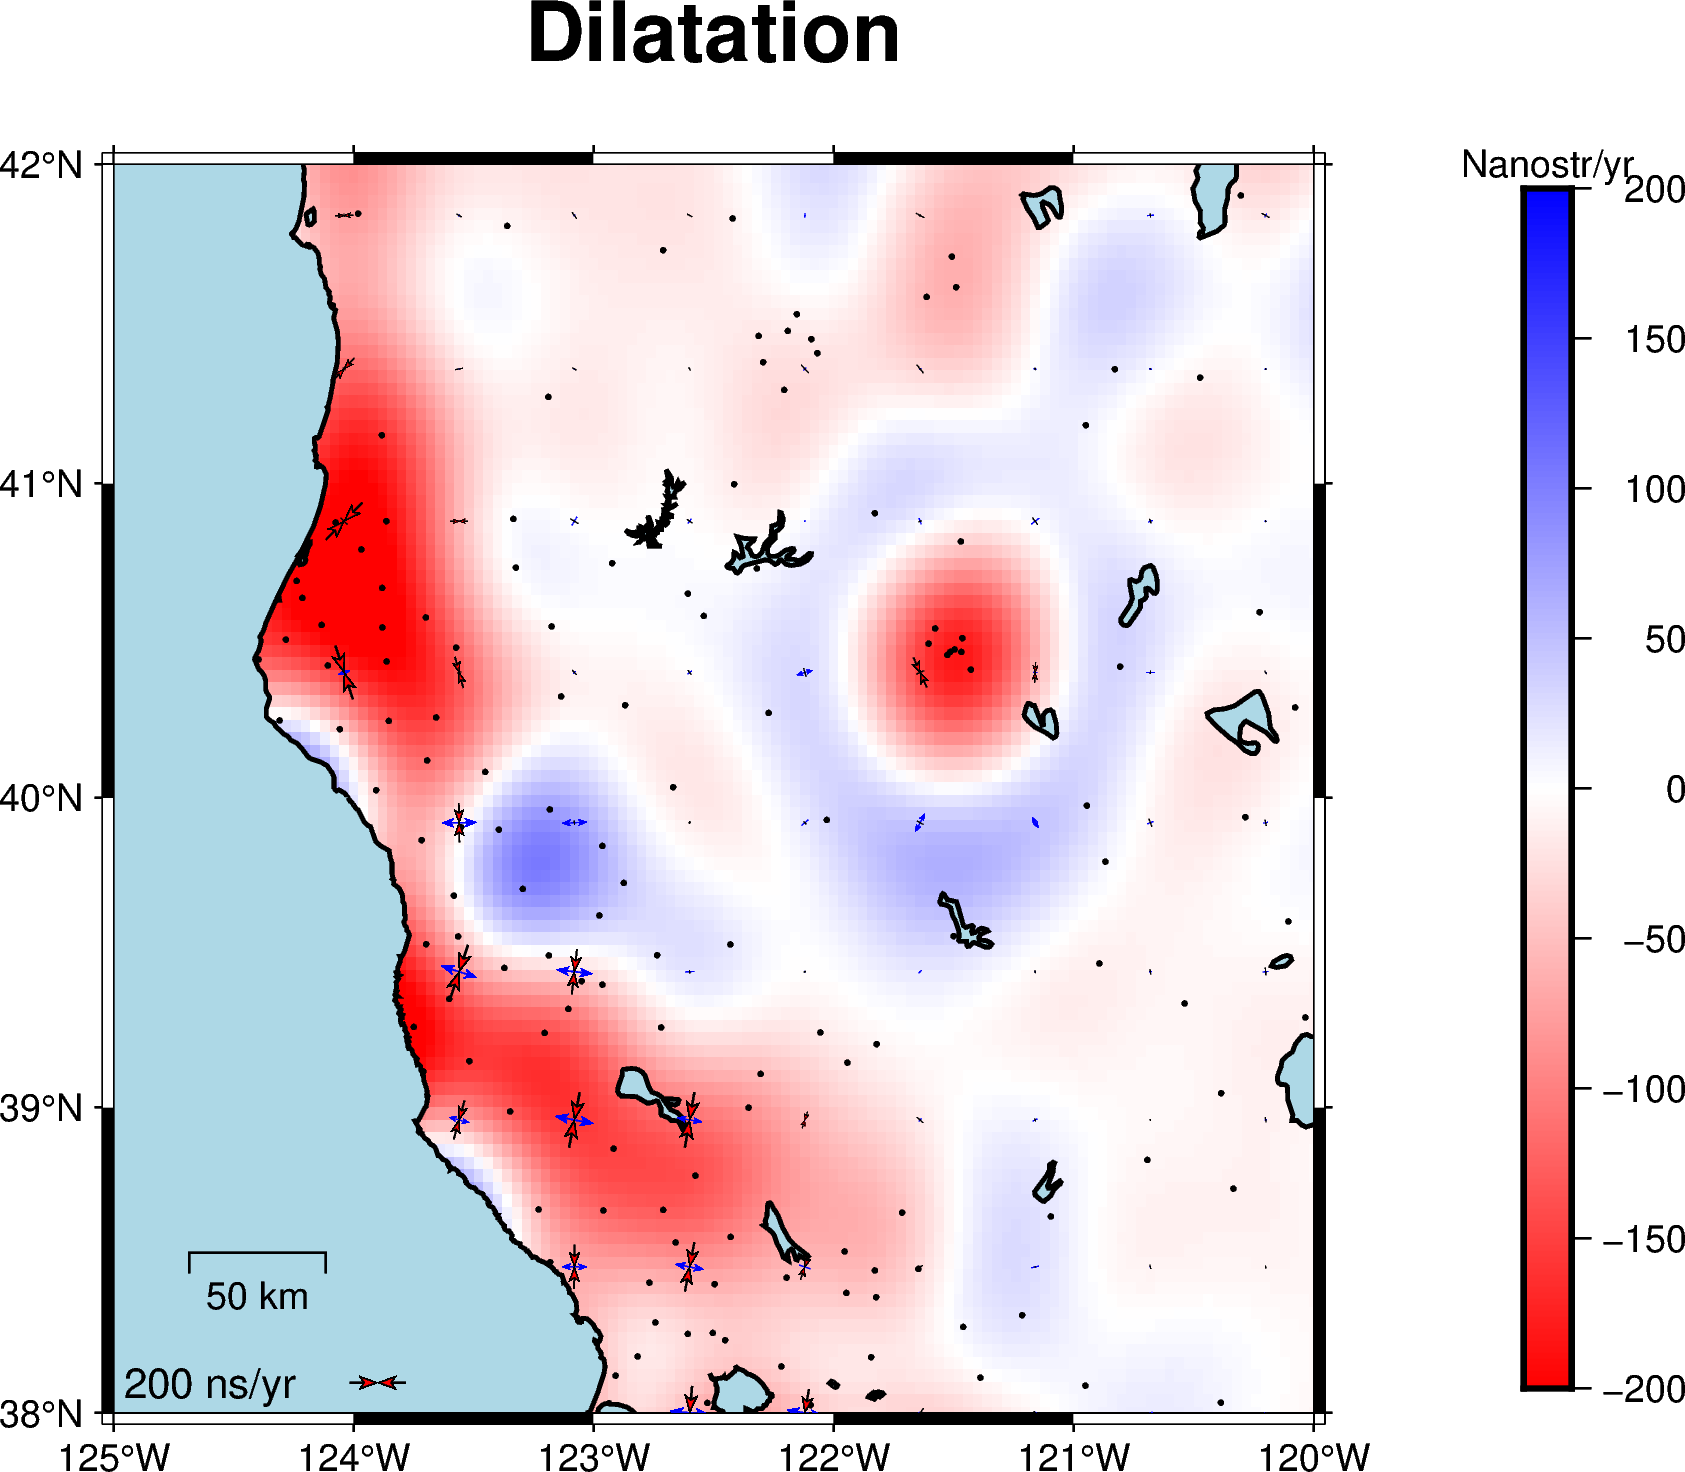

Max shear strain rate:
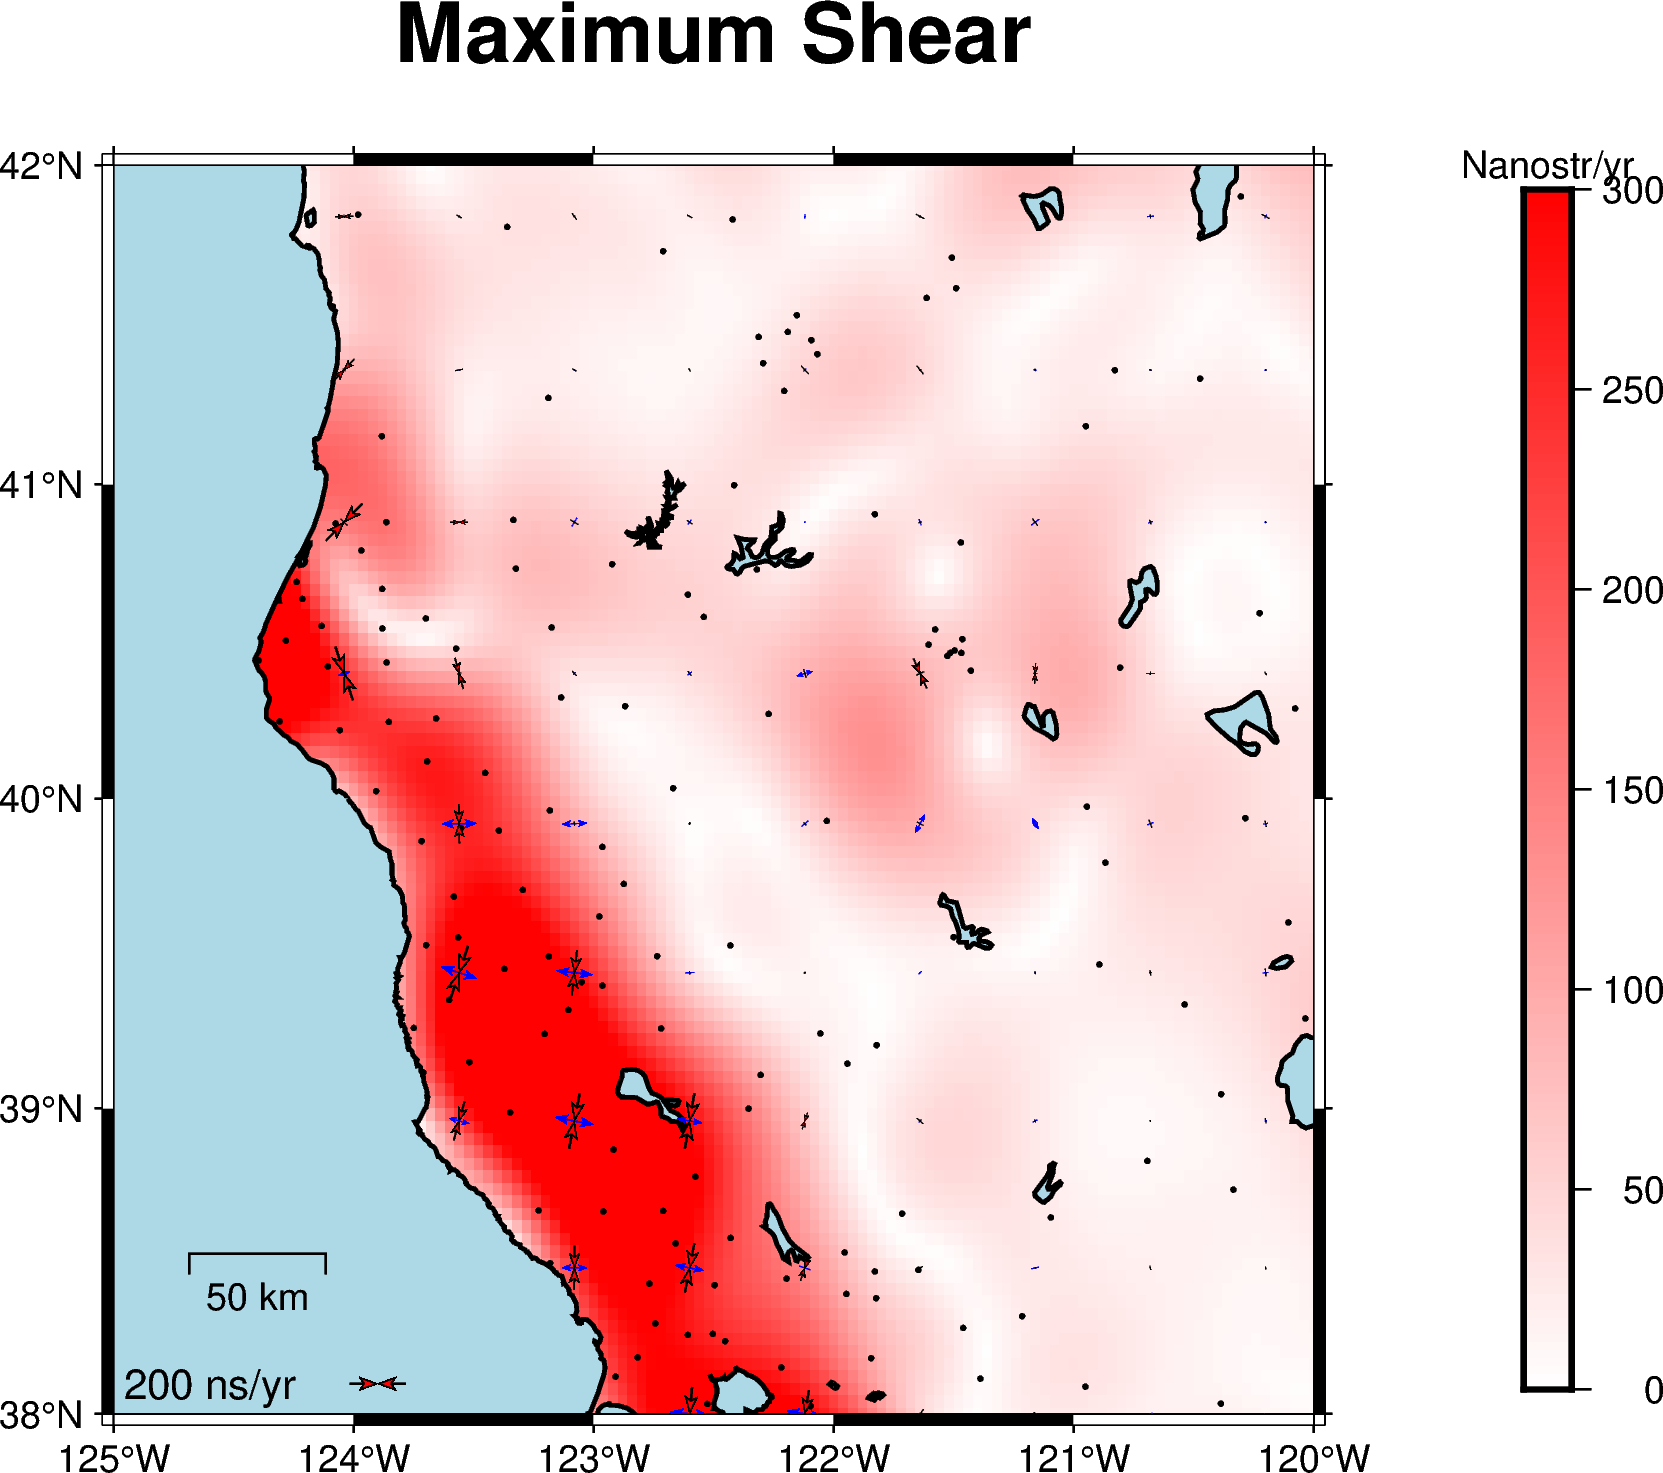

Comparing the geostats and delaunay results, you can see that they do have similar broad-scale features, with some important differences. 

Let's run the _gpsgridder_ method and see how that compares: 

In [37]:
!strain_rate_compute.py 02_strain_config_gpsgridder.txt


------------------------------
Hello! We are...
   Computing strain using : gpsgridder 
   Input data from        : ../test/testing_data/NorCal_stationvels.txt
   Calculation range      : [-125.0, -120.0, 38.0, 42.0]
   Putting the outputs    : Output/gpsgridder/ 

------------------------------
Reading file ../test/testing_data/NorCal_stationvels.txt 
284 stations before applying cleaning.
233 stations after imposing bounding box.

------------------------------
Computing strain via gpsgridder method.
writing vector output file tempgps.txt 
gmt gpsgridder tempgps.txt -R-125.02/-119.98/37.98/42.02 -I0.04/0.04 -S0.5 -Fd0.01 -C0.0001 -Emisfitfile.txt -fg -r -Gnc_%s.nc
rm: gmt.history: No such file or directory
Success computing strain via gpsgridder method.

------------------------------
Writing 2d outputs:
writing human-readable velfile in station-vel format, Output/gpsgridder/obs_vels.txt
writing human-readable velfile in station-vel format, Output/gpsgridder/residual_vels.txt
Comput

### Plots

Dilatation: 
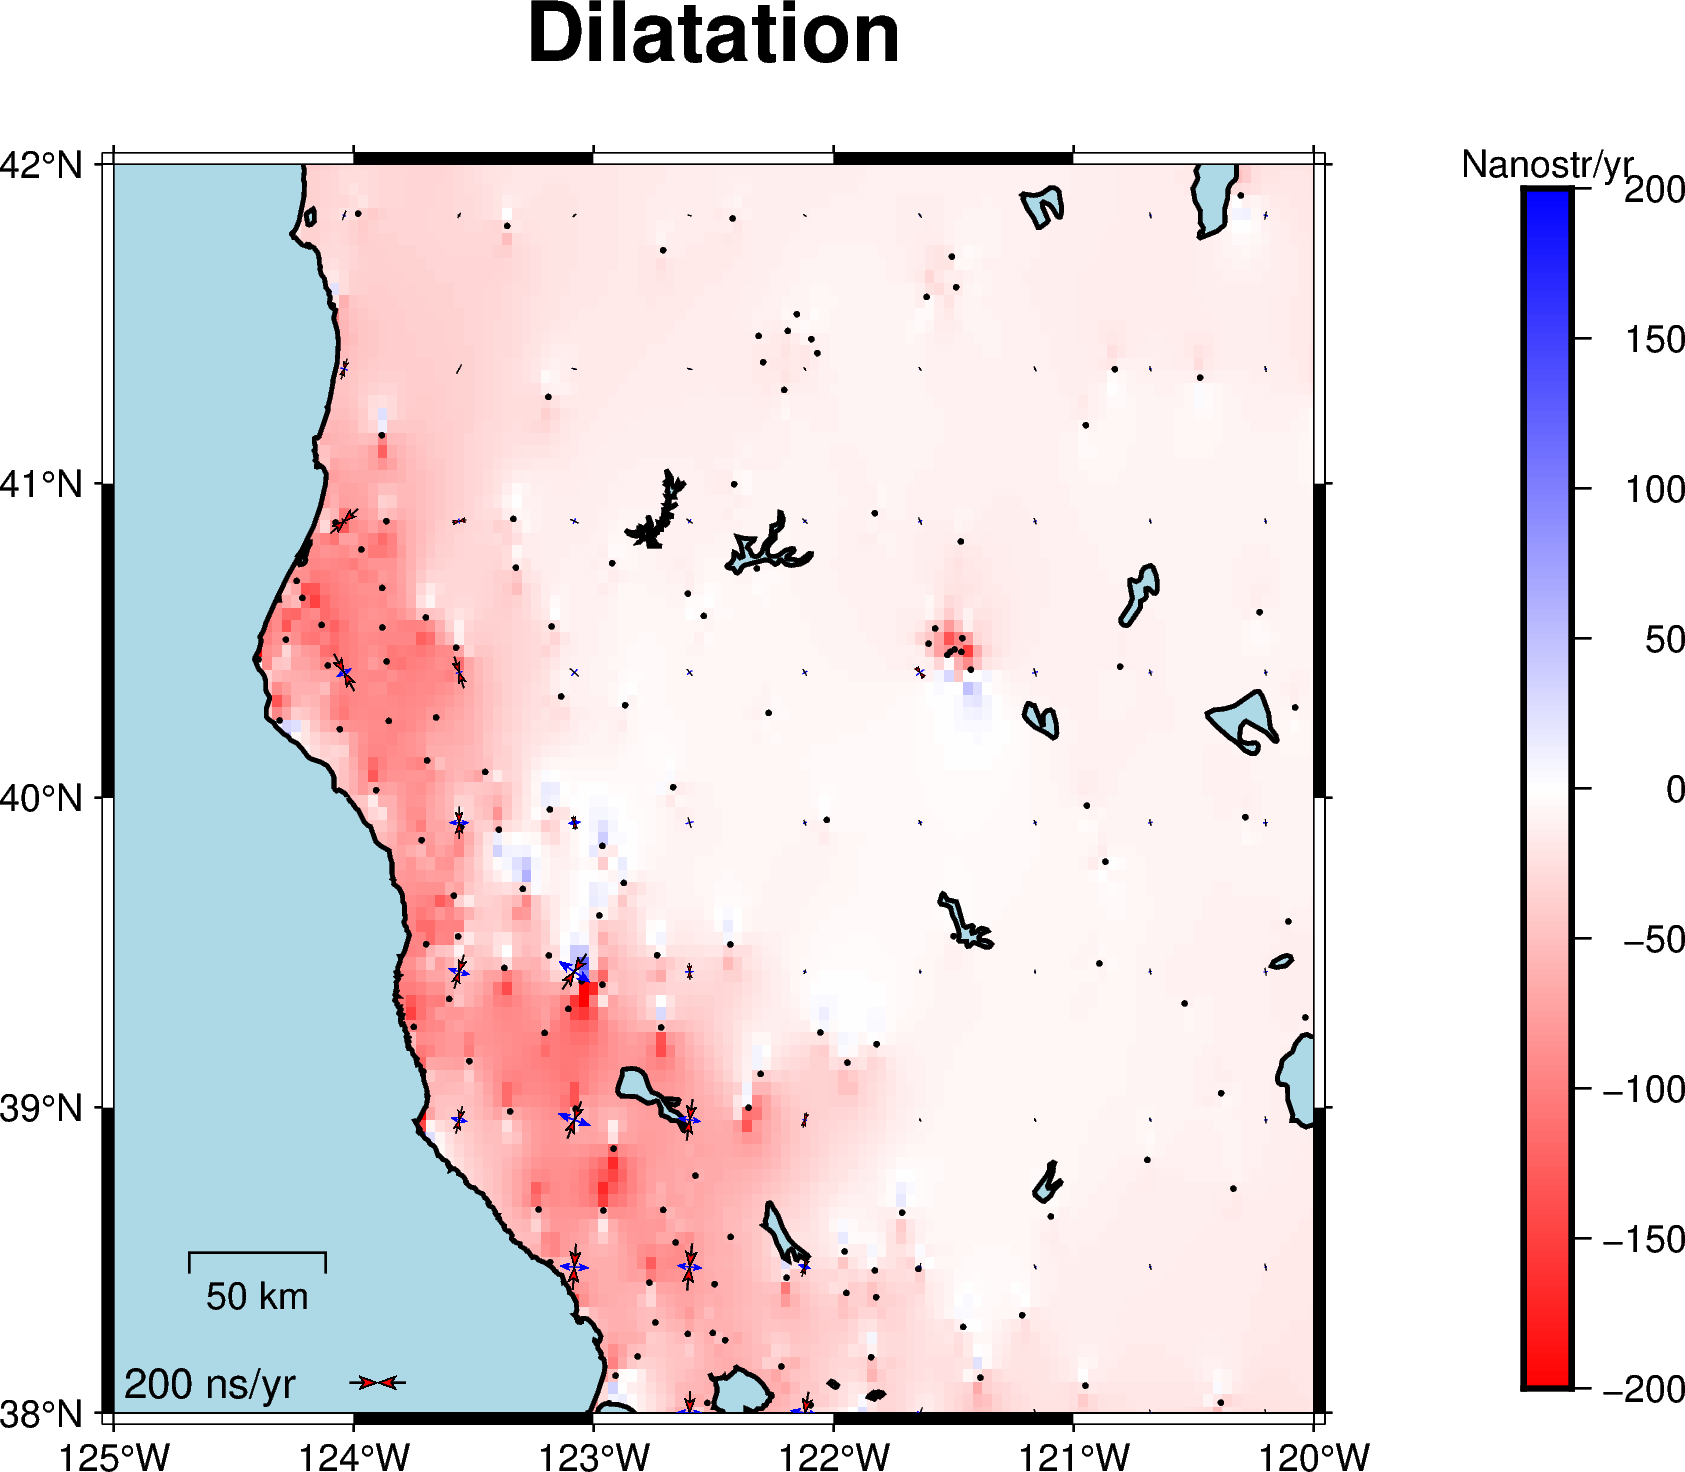

Max shear strain rate:
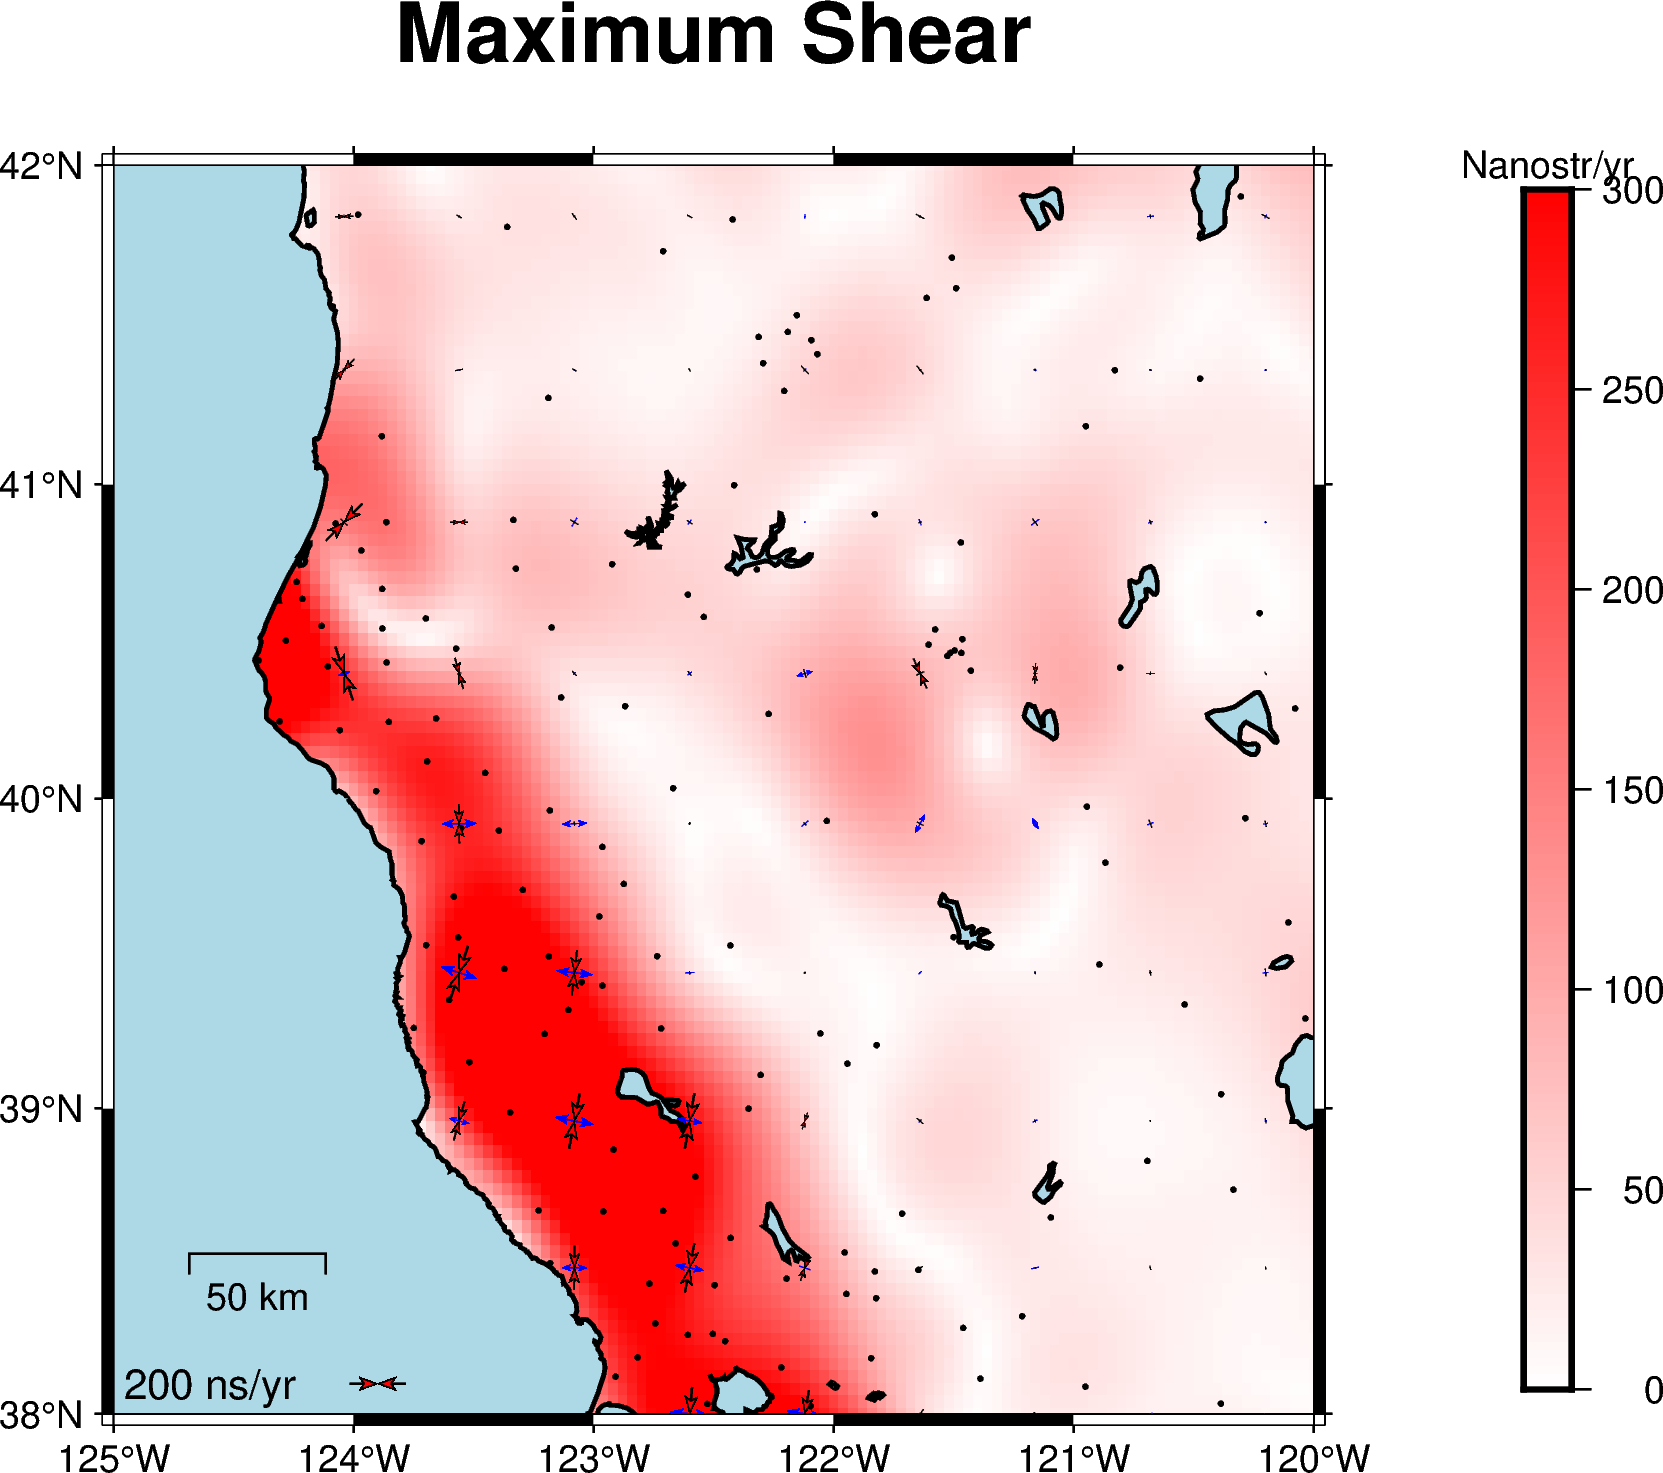


The _gpsgridder_ method is even much smoother than the geostats method, in the sense that the strain variations are smaller. 

One more method to run is _local average gradient_, and then we'll compare all methods side-by-side. 

In [38]:
!strain_rate_compute.py 03_strain_config_loc_avg_grad.txt


------------------------------
Hello! We are...
   Computing strain using : loc_avg_grad 
   Input data from        : ../test/testing_data/NorCal_stationvels.txt
   Calculation range      : [-125.0, -120.0, 38.0, 42.0]
   Putting the outputs    : Output/loc_avg_grad/ 

------------------------------
Reading file ../test/testing_data/NorCal_stationvels.txt 
284 stations before applying cleaning.
233 stations after imposing bounding box.

------------------------------
Computing strain via loc_avg_grad method.
Success computing strain via loc_avg_grad method.

------------------------------
Writing 2d outputs:
writing human-readable velfile in station-vel format, Output/loc_avg_grad/obs_vels.txt
writing human-readable velfile in station-vel format, Output/loc_avg_grad/residual_vels.txt
Computing strain invariants for 2d dataset.
Writing file Output/loc_avg_grad/loc_avg_grad_strain.nc 
Max I2: 77542.692678 
Min/Max rot:   -29.959303,   401.828217 
writing vector output file Output/loc_av

## Comparing methods

Strain_2D provides the `strain_rate_compare.py` script that takes a simple list of directories. 

In [39]:
# Take a look at strain_compare_config.txt before running this cell to look at how the individual methods get called
!strain_rate_comparison.py 04_strain_compare_config.txt


------------------------------
Hello! We are comparing strain calculations...
   Comparing strain from calculations : 
  dict_values(['Output/delaunay', 'Output/gpsgridder', 'Output/loc_avg_grad', 'Output/geostats']) 
   Putting the outputs    : Output/_strain_comparison 

All methods have the same shape.
Saving Method Differences as Output/_strain_comparison/separate_plots_max_shear.png.
All methods have the same shape.
Saving Method Differences as Output/_strain_comparison/separate_plots_dilatation.png.
All methods have the same shape.
All methods have the same shape.
All methods have the same shape.
Saving I2nd figure as Output/_strain_comparison/means_I2nd.png.
Saving dilatation figure as Output/_strain_comparison/means_dila.png.
Saving MaxShear figure as Output/_strain_comparison/means_max_shear.png.
Saving azimuth figure as Output/_strain_comparison/means_azimuth.png.
Saving rotation figure as Output/_strain_comparison/means_rot.png.


### Plots

We can calculate the mean of all the models. 

Dilatation: 
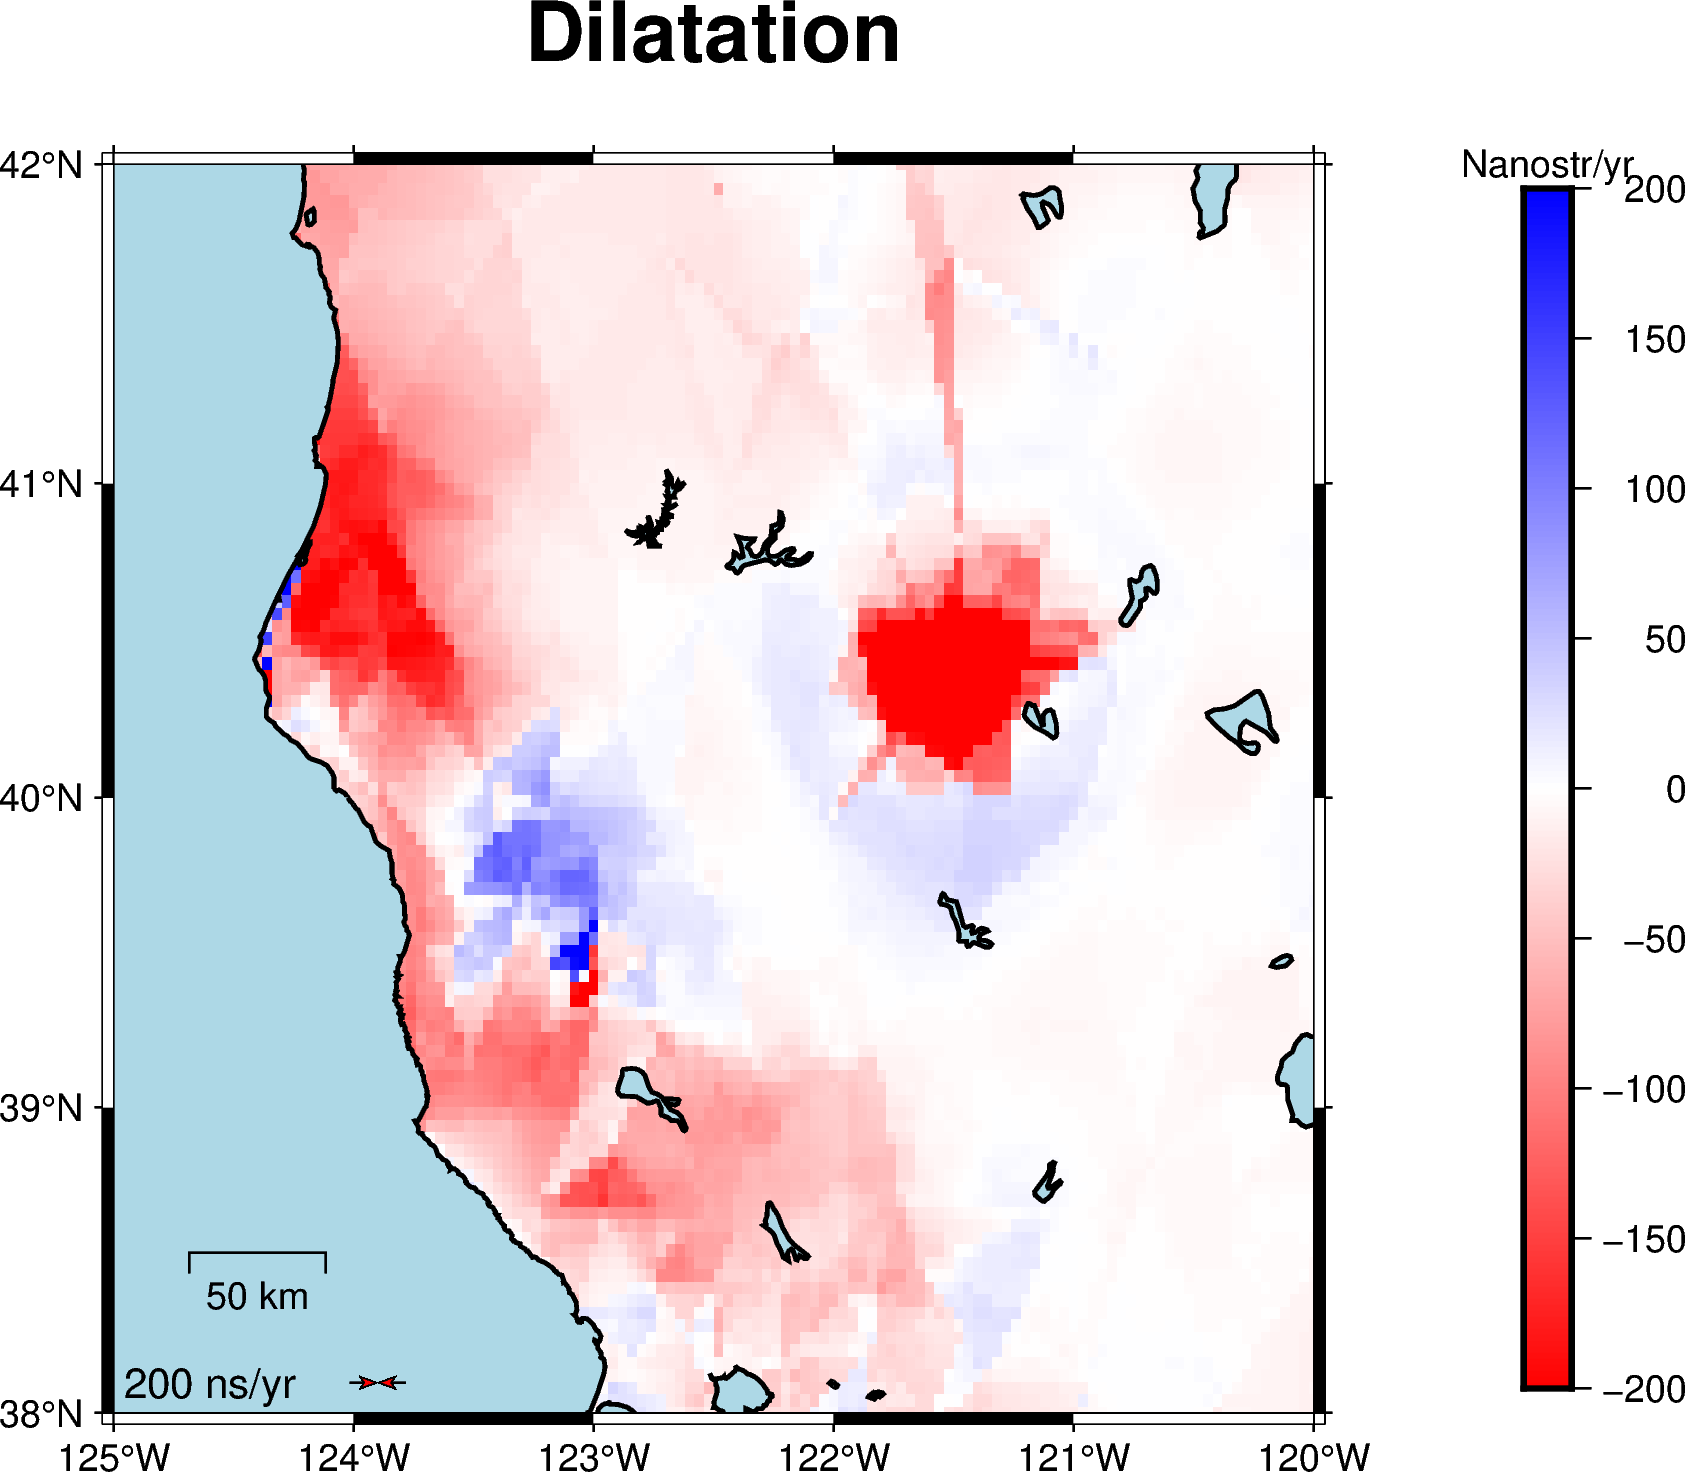

Max shear strain rate:
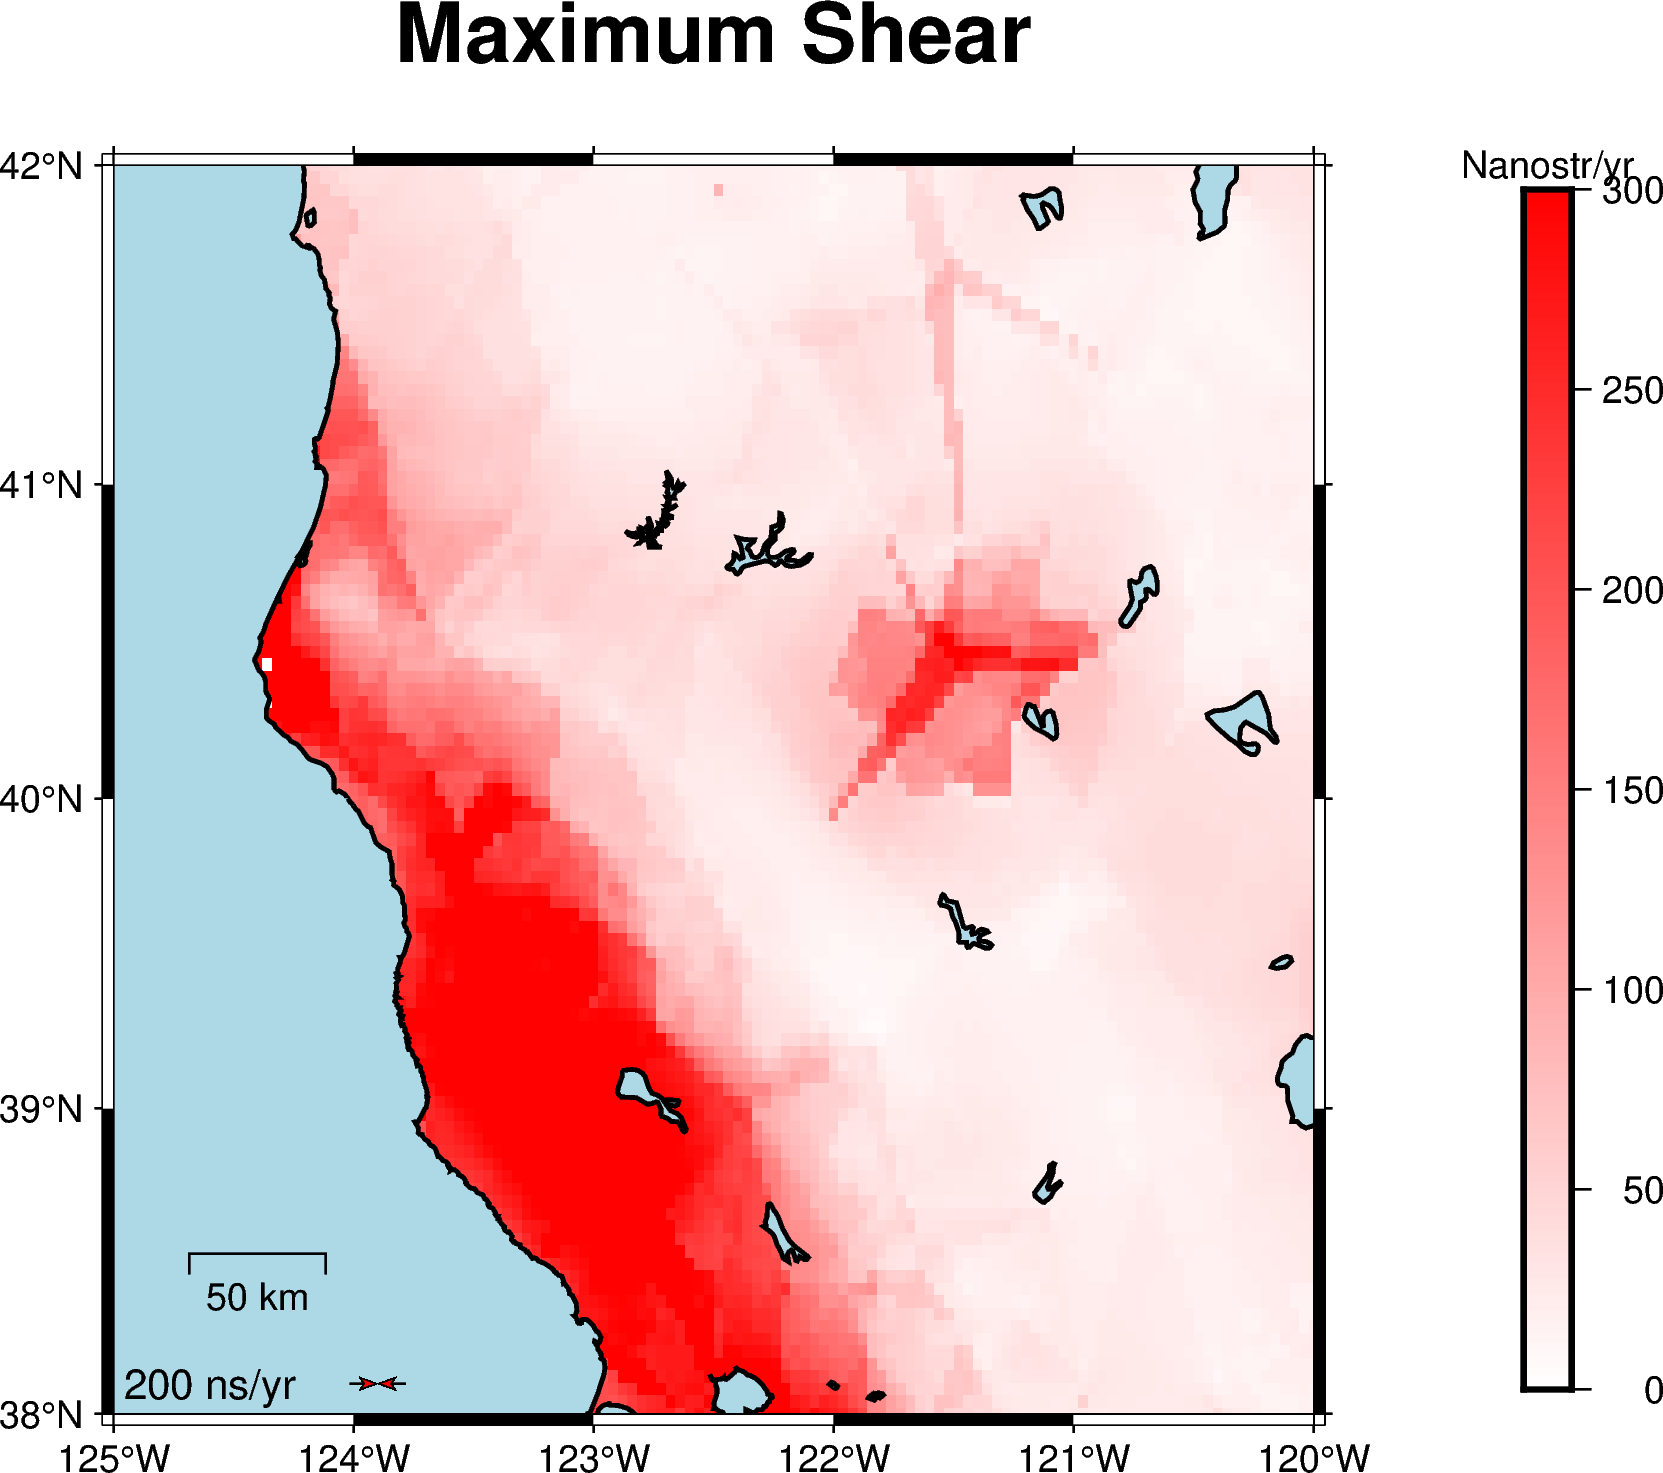


We can look at all the results in a single plot. 
The example below compares the dilation rate across all methods. 

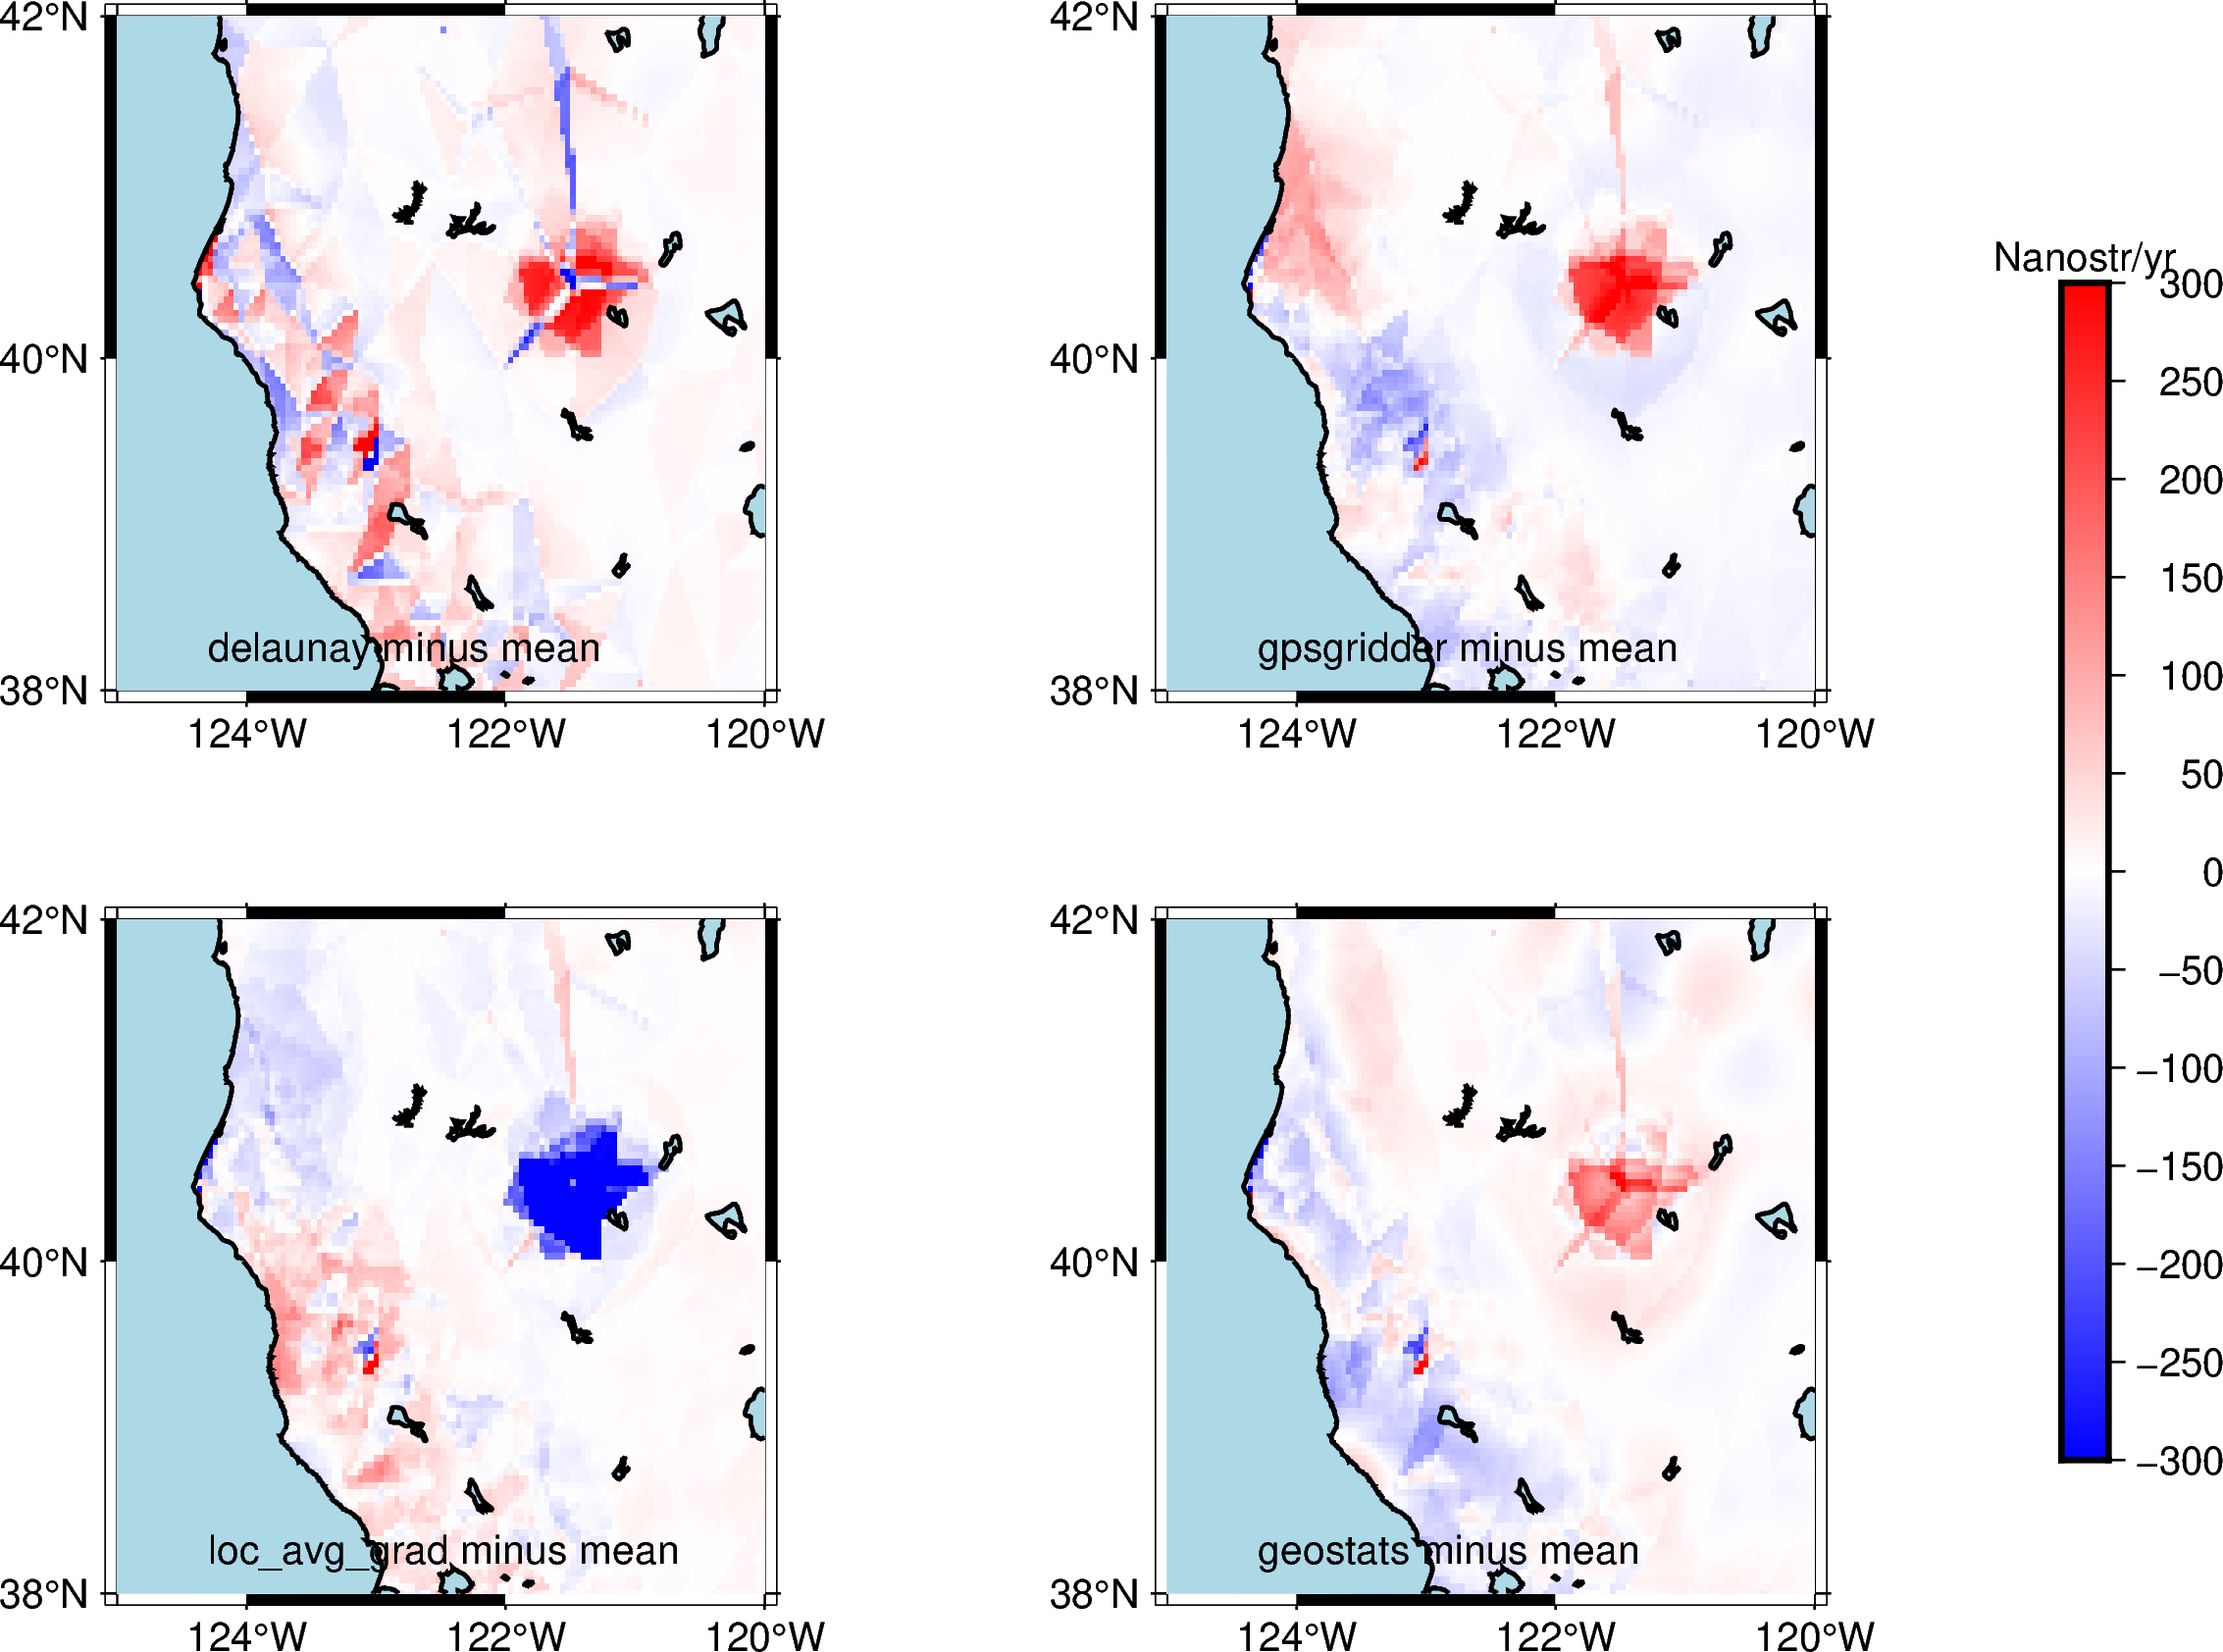